<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Singular-Value-Decomposition-(SVD)" data-toc-modified-id="Singular-Value-Decomposition-(SVD)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Singular Value Decomposition (SVD)</a></span><ul class="toc-item"><li><span><a href="#Interpretation-of-SVD" data-toc-modified-id="Interpretation-of-SVD-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Interpretation of SVD</a></span><ul class="toc-item"><li><span><a href="#Geometric-Interpretation" data-toc-modified-id="Geometric-Interpretation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Geometric Interpretation</a></span></li><li><span><a href="#Factor-Interpretation" data-toc-modified-id="Factor-Interpretation-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Factor Interpretation</a></span></li></ul></li><li><span><a href="#Worked-Example-Full-SVD" data-toc-modified-id="Worked-Example-Full-SVD-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Worked Example Full SVD</a></span></li><li><span><a href="#Relationships-with-PCA" data-toc-modified-id="Relationships-with-PCA-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Relationships with PCA</a></span></li><li><span><a href="#Applications" data-toc-modified-id="Applications-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Applications</a></span><ul class="toc-item"><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Dimensionality Reduction</a></span></li><li><span><a href="#Information-Retrieval" data-toc-modified-id="Information-Retrieval-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Information Retrieval</a></span></li><li><span><a href="#Collaborative-Filtering" data-toc-modified-id="Collaborative-Filtering-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Collaborative Filtering</a></span></li></ul></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd as scipy_svd
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,matplotlib

Ethen 2017-11-18 21:13:40 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
sklearn 0.19.1
matplotlib 2.1.0


# Singular Value Decomposition (SVD)

When conducting data analysis project, it's very common to encounter dataset that contains some useful information to the task at hand, but also contains low quality information that do not contribute too much to the end goal. When facing this issue, there are numerous ways to isolating the signal from the noise. e.g. We can employ regularization methods such as [Lasso regression](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/regularization/regularization.ipynb) to perform constrained optimization, automatically dropping uninformative features from the model or use [tree-based methods](https://github.com/ethen8181/machine-learning#trees--20161210) to identify the features that were most often used for constructing the tree.

Or use a variance maximization method such as [Principal Component Analysis (PCA)](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/dim_reduct/PCA.ipynb) that aims to transform the data into a new set of orthogonal components, ensuring that the first component aligns to the maximum variance in the dataset, and the subsequent component aligns with the next maximum component and so on. In other words, it makes a dataset more compact while preserving information. The convention method for calculating PCA requires us to compute the full covariance matrix, making it suffer from extensive use of memory and can be numerically unstable. It turns out, SVD is a method that can be used to compute PCA and obtain the principal component to transform our raw dataset.

**Singular Value Decomposition (SVD)** is a particular decomposition method that decomposes an arbitrary matrix $A$ with $m$ rows and $n$ columns (assuming this matrix also has a rank of $r$, i.e. $r$ columns of the matrix $A$ are linear independent) into a set of related matrices:

$$
\begin{align}
A = U \Sigma V^{T}
\end{align}
$$

where:

- $\Sigma$ (Sigma) is a $r * r$ non-negative, decreasing order diagonal matrix. All elements not on the main diagonal are
0 and the elements of $\Sigma$ are called the singular values. Another common notation that is used for this matrix is $S$. Thus in the following post, we'll use these two symbols interchangeably.

- $U$ is a $m * r$ orthonormal matrix and $V$ is a $n * r$ orthonormal matrix.
    - Orthogonal matrix refers to a square matrix where the columns are 90 degrees between each other and its inner dot product is zero, i.e. Given a orthogonal matrix $Q$, $Q^T Q = Q Q^T = I$ and $Q^T = Q^{-1}$.
    - Orthonormal matrix: orthogonal matrix where columns are unit vectors.

A classic pictorial representation of SVD.

<img src="img/svd.png" width="60%" height="60%">

## Interpretation of SVD

### Geometric Interpretation

We'll use a 2 dimensional dataset for the geometric interpretation for ease of visualization. Transformation of a matrix by $U \Sigma V^T$ can be visualized as a rotation and reflection, scaling, rotation and reflection. We'll see this as a step-by-step visualization.

Given a matrix $x = \begin{bmatrix} -10 & -10 & 20 & 20\\ -10 & 20 & 20 & -10 \end{bmatrix}$ and a transformation matrix $A = \begin{bmatrix} 1 & 0.3 \\ 0.45 & 1.2 \end{bmatrix}$.

- $V^T x$ We can see that multiplying by $V^T$ rotates and reflects the input matrix $x$. Notice the swap of colors red-blue and green-yellow indicating a reflection along the x-axis.

<img src="img/Vx_plot.png" width="30%" height="30%">

- $S V^T x$ Since $S$ only contains values on the diagonal, it scales the matrix. $V$ rotates the matrix to a position where the singular values now represent the scaling factor along the V-basis. In the picture below $V^Tx$ is dashed and $SV^Tx$ is solid.

<img src="img/SVx_plot.png" width="30%" height="30%">

- $U S V^T$ Finally, $U$ rotates and reflects the matrix back to the standard basis.

<img src="img/USVx_plot.png" width="30%" height="30%">

Putting all three steps into one picture below, the dashed square shows $x$ as the corners and the transformed matrix $Ax$ as the solid shape.

<img src="img/transformed_plot.png" width="25%" height="25%">

The most useful property of the SVD is that the axes in the new space, which represent new latent attributes, are orthogonal. Hence original attributes are expressed in terms of new attributes that are independent of each other.

In [3]:
# we can confirm this with code
A = np.array([[1, 0.3], [0.45, 1.2]])
U, S, V = scipy_svd(A)
print('singular values:', S)

# the toy 2d matrix
x = np.array([[-10, -10, 20, 20], [-10, 20, 20, -10]]).T
x

singular values: [ 1.49065822  0.71444949]


array([[-10, -10],
       [-10,  20],
       [ 20,  20],
       [ 20, -10]])

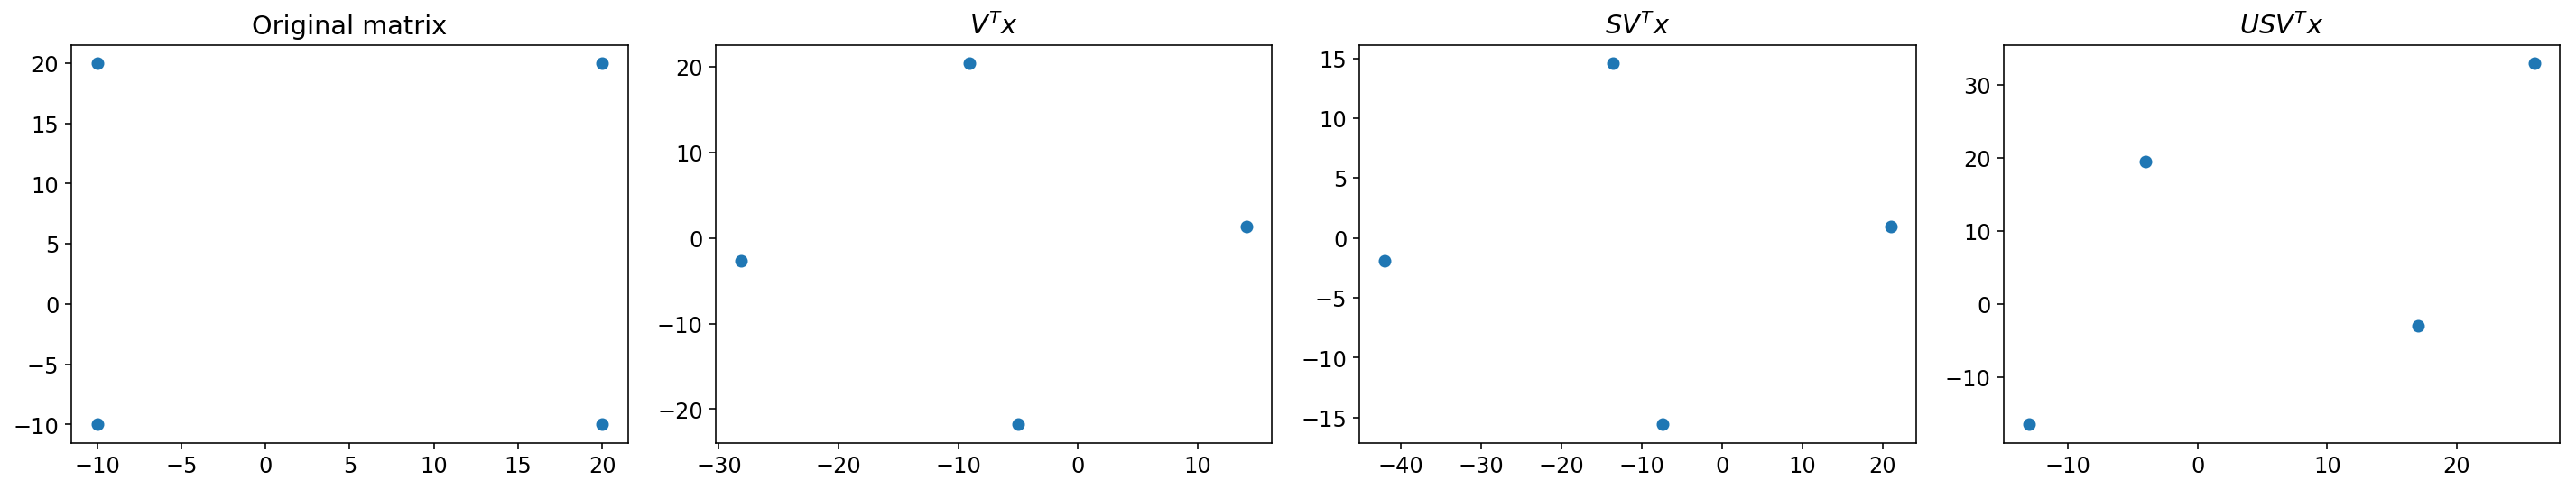

In [4]:
# change default font size
plt.rcParams['font.size'] = 12 

# the plot is not as pretty as the diagram above,
# but hopefully it gets the point across
fig, ax = plt.subplots(1, 4, figsize = (20, 4))

ax[0].scatter(x[:, 0], x[:, 1])
ax[0].set_title('Original matrix')

temp = x @ V.T
ax[1].scatter(temp[:, 0], temp[:, 1])
ax[1].set_title('$V^Tx$')

temp = temp @ np.diag(S)
ax[2].scatter(temp[:, 0], temp[:, 1])
ax[2].set_title('$SV^Tx$')

temp = temp @ U
ax[3].scatter(temp[:, 0], temp[:, 1])
ax[3].set_title('$USV^Tx$')

plt.tight_layout()
plt.show()

### Factor Interpretation

Here we are given a rank 3 matrix $A$, representing ratings of movies by users.

| Name  | Matrix | Alien | Star Wars | Casablanca | Titanic |
| ----- | ------ | ----- | --------- | ---------- | ------- |
| Joe   | 1      | 1     | 1         | 0          | 0       |
| Jim   | 3      | 3     | 3         | 0          | 0       |
| John  | 4      | 4     | 4         | 0          | 0       |
| Jack  | 5      | 5     | 5         | 0          | 0       |
| Jill  | 0      | 2     | 0         | 4          | 4       |
| Jenny | 0      | 0     | 0         | 5          | 5       |
| Jane  | 0      | 1     | 0         | 2          | 2       |

Applying SVD to this matrix will give us the following decomposition:

<img src="img/decomposed.png" width="60%" height="60%">

The key to understanding what SVD offers is viewing the $r$ columns of $U$, $\Sigma$, and $V$ as representing concepts that are hidden in the original matrix. In our contrived example, we can imagine there are two concepts underlying the movies, scientific fiction and romance.

To be explicit:

- The matrix $U$ connects people to concept. For example, looking at Joe (the first row in the original matrix). The value 0.14 in the first row and first column of $U$ is smaller than some of the other entries in that column. The rationale for this is because while Joe watches only science fiction, he doesn’t rate those movies highly.
- The matrix $V$ relates movies to concept. The approximately 0.58 in each of the first three columns of the first row of $V^T$ indicates that the first three movies – The Matrix, Alien and Star Wars – each are of science-fiction genre.
- Matrix $\Sigma$ gives the strength of each of the concepts. In our example, the strength of the science-fiction concept is 12.4, while the strength of the romance concept is 9.5. Intuitively, the science-fiction concept is stronger because the data provides more information about the movies of that genre and the people who like them.
- The third concept is a bit harder to interpret, but it doesn't matter that much, because its weight, given by the third nonzero diagonal entry in $\Sigma$ is relatively low compared to the first two concepts.
- Note that the matrix decomposition doesn't know the meaning of any column in the dataset, it discovers the underlying concept and it is up to us to interpret these latent factors.

## Worked Example Full SVD

Let's step through a worked example of "Full" SVD. In practice the full version is computationally expensive, since we must calculate the full matrices $U_{mr}$, $S_{rr}$, and $V_{nr}^{T}$. The "truncated" versions of SVD are usually preferred, where we can preselect the top $k < r$ dimensions of interest and calculate $U_{mk}$, $S_{kk}$ and $V_{nk}^{T}$. But the truncated version is a topic for another day.

In [5]:
# matrix form of the table above
rank = 3
A = np.array([
    [1, 1, 1, 0, 0],
    [3, 3, 3, 0, 0],
    [4, 4, 4, 0, 0],
    [5, 5, 5, 0, 0],
    [0, 2, 0, 4, 4],
    [0, 0, 0, 5, 5],
    [0, 1, 0, 2, 2]])

# we'll use a library to perform the svd
# so we can confirm our result with it
U, S, V = scipy_svd(A, full_matrices = False)

# we'll just print out S, a.k.a Sigma to show the numbers
# are identical to the results shown earlier
print(S)

[  1.24810147e+01   9.50861406e+00   1.34555971e+00   3.04642685e-16
   0.00000000e+00]


In [6]:
# the following cell verifies some properties of SVD

# Verify calculation of A=USV^T
print(np.allclose(A, U @ np.diag(S) @ V))

# orthonormal, columns are unit vectors (length = 1)
print(np.allclose(np.round(np.sum(U * U, axis = 0)), np.ones(S.size)))

# orthogonal, dot product of itself is equivalent to
# the identity matrix U^T U = I
print(np.allclose(U.T @ U, np.eye(S.size)))

True
True
True


The SVD of a matrix $A$ is strongly connected to the eigenvalues of the symmetric matrices $A^{T}A$ and $AA^{T}$. We'll start with the expression for SVD: $A = U \Sigma V^T$.

$$
\begin{align}
A^T
&= (U \Sigma V^T)^T \\
&= (V^T)^T \Sigma^T U^T \\
&= V \Sigma^T U^T \\
&= V \Sigma U^T
\end{align}
$$

In the second step we use the matrix property that $(BA)^T = A^T B^T$ and in the final step $\Sigma$ is a diagonal matrix, thus $\Sigma^T = \Sigma$. Next:

$$
\begin{align}
A^T A
&= (V \Sigma U^T)(U \Sigma V^T)  \\
&= V \Sigma I \Sigma V^T \\
&= V \Sigma \Sigma V^T
\end{align}
$$

In the second step, we use the fact that $U$ is a orthonormal matrix, so $U^T U$ is an identity matrix of the appropriate size.

We now multiply both sides of this equation by $V$ to get:

$$
\begin{align}
A^T A V
&= V \Sigma^2 V^T V \\
&= V \Sigma^2 I \\
&= V \Sigma^2
\end{align}
$$

Here we use the fact that $V$ is also a orthonormal matrix, so $V^T V$ is an identity matrix of the appropriate size. Looking at the equation $A^T A V = V \Sigma^2$, we now see that $V$ is the eigenvector of the matrix $A^T A$ and $\Sigma^2$ is the diagonal matrix whose entries are the corresponding eigenvalues. i.e. $V = eig(A^T A)$

In [7]:
AtA = A.T @ A
_, V1 = np.linalg.eig(AtA)

# Note that the possible non-uniqueness of the decomposition means
# that an axis can be flipped without changing anything fundamental,
# thus we compare whether the absolute values are relatively close
# instead of the raw value
print(np.allclose(np.abs(V1[:, :rank]), np.abs(V1[:, :rank])))

True


Only $U$ remains to be computed, but it can be found in the same way we found $V$. Instead this time, we'll be starting with $A A^T$

$$
\begin{align}
A A^T U
&= (U \Sigma V^T)(V \Sigma U^T) U \\
&= V \Sigma I \Sigma V^T U \\
&= U \Sigma \Sigma U^T U \\
&= U \Sigma \Sigma I \\
&= U \Sigma^2
\end{align}
$$

In other words: $U = eig(A A^T)$

In [8]:
AAt = A @ A.T
_, U1 = np.linalg.eig(AAt)
np.allclose(np.abs(U1[:, :rank]), np.abs(U[:, :rank]))

True

In [9]:
# notice that since this is a rank 3 matrix
# only the first 3 values of 3 contains non-zero values
np.round(S, 0)

array([ 12.,  10.,   1.,   0.,   0.])

To sum this section up:

- $U$ is a $m * r$ orthonormal matrix of "left-singular" (eigen)vectors of $AA^{T}$.
- $V$ is a $n * r$ orthonormal matrix of 'right-singular' (eigen)vectors of $A^{T}A$.    
- $\Sigma$ is a $r * r$ non-negative, decreasing order diagonal matrix. All elements not on the main diagonal are
0 and the elements of $\Sigma$ are called the singular values, which is the square root of nonzero eigenvalues.

For those interested, the following link contains a detail walkthrough of the computation by hand. [Notes: Singular Value Decomposition Tutorial](https://datajobs.com/data-science-repo/SVD-Tutorial-[Kirk-Baker].pdf)

## Relationships with PCA

This usage of SVD is very similar to Principal Components Analysis (PCA) and in fact several numerical software libraries actually use SVD under the hood for their PCA routines, for example `sklearn.decomposition.PCA` within scikit-learn. This is due to the fact that it is more numerically stable and it's also possible to perform a truncated SVD, which only needs us to calculate $U \Sigma V^T$ for the first $k<n$ features; this makes it far quicker to compute than the full covariance matrix as computed within PCA.

In the following section, we'll take a look at the relationship between these two methods, PCA and SVD. Recall from the documentation on [PCA](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/dim_reduct/PCA.ipynb), given the input matrix $\mathbf X$ the math behind the algorithm is to solve the eigendecomposition for the correlation matrix (assuming we standardized all features) $\mathbf C = \mathbf X^T \mathbf X / (n - 1)$. It turns out, we can represent $\mathbf C$ by a product of its eigenvectors $\mathbf W$ and diagonalized eigenvalues $\mathbf L$.

$$
\begin{align}
\mathbf C &= \mathbf W \mathbf L \mathbf W^T
\end{align}
$$

In [10]:
# use some toy dataset
iris = load_iris()
X = iris['data']

# construct the pipeline
standardize = StandardScaler()
pca = PCA()
pipeline = Pipeline([
    ('standardize', standardize),
    ('pca', pca)
])
X_pca = pipeline.fit_transform(X)

In [11]:
standardize = pipeline.named_steps['standardize']
X_std = standardize.transform(X)

# confirm the WLW^T 
X_cov = np.cov(X_std.T)
eigen_values, eigen_vecs = np.linalg.eig(X_cov)
reconstructed_X = eigen_vecs @ np.diag(eigen_values) @ np.linalg.inv(eigen_vecs)
print(np.allclose(X_cov, reconstructed_X))

True


After obtaining the eigenvectors, i.e. principal direrctions, we can project our raw data onto the principal axes, which are called principal component scores via the operation $\mathbf{XW}$.

As for singular decompostion, $\mathbf X = \mathbf U \mathbf \Sigma \mathbf V^T$. We can write out the correlation matrix using this form:

$$
\begin{align}
\mathbf C
&= \mathbf V \mathbf \Sigma \mathbf U^T \mathbf U \mathbf \Sigma \mathbf V^T / (n - 1) \\
&= \mathbf V \frac{\mathbf \Sigma^2}{n - 1}\mathbf V^T
\end{align}
$$

Meaning thte right singular vectors $\mathbf V$ are principal directions and that singular values are related to the eigenvalues of correlation matrix via $\mathbf L = \mathbf \Sigma^2 / (n - 1)$ And the principal component scores can be computed by: $\mathbf X \mathbf V = \mathbf U \mathbf \Sigma \mathbf V^T \mathbf V = \mathbf U \mathbf \Sigma$.

In [12]:
# here we'll print out the eigenvectors
# learned from PCA and the V learned from svd
pca.components_

array([[ 0.52237162, -0.26335492,  0.58125401,  0.56561105],
       [ 0.37231836,  0.92555649,  0.02109478,  0.06541577],
       [-0.72101681,  0.24203288,  0.14089226,  0.6338014 ],
       [-0.26199559,  0.12413481,  0.80115427, -0.52354627]])

In [13]:
# we can do X @ V to obtain the principal component score
U, S, V = scipy_svd(X_std)
V

array([[ 0.52237162, -0.26335492,  0.58125401,  0.56561105],
       [-0.37231836, -0.92555649, -0.02109478, -0.06541577],
       [ 0.72101681, -0.24203288, -0.14089226, -0.6338014 ],
       [ 0.26199559, -0.12413481, -0.80115427,  0.52354627]])

Notice that some of the signs are flipped, this is normal due to the previously stated non-uniqueness of the decomposition. We'll now wrap up this section with a diagram of PCA versus SVD:

<img src="img/pca_versus_svd.png" width="60%" height="60%">

## Applications

This is by no means an exhaustive list of SVD's application.

### Dimensionality Reduction

Due to its relationships with PCA, we can imagine a very frequent use of SVD is feature reduction. By only selecting the top $k$ singular values, we have in effect compressed the original information and represented it using fewer features. Note that because SVD is also a numerical algorithm, it is important to standardize the features to ensure the magnitude of the entries are of similar range.

### Information Retrieval

SVD has also been used extensively in information retrieval, in this particular application, it is also known as Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI). As we'll soon see, the idea is very similar to [topic modeling](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/topic_model/LDA.ipynb). The fundamental problem in information retrieval is: given some search terms, retrieve all of the documents that contain those search terms or, perhaps more usefully, return documents whose content is semantically related to the search terms. For example, if one of the search terms was "automobile" it might be appropriate to return also documents that contain the search term "car".

One approach to this problem is: Given an information repository, we might convert a raw text to document-term matrix with one row per document and one column per word. Then convert the search term as a vector in the same space, and retrieving document vectors that are close to the search vector. There are several problems with vector-based retrieval.

- First, the space is very high dimensional. For example, a typical collection of documents can easily mention more than 100,000 words even if stemming is used (i.e., "skip", "skipping", "skipped" are all treated as the same word). This creates problems for distance measurement due to the curse of dimensionality.
- Second, it treats each word as independent, whereas in languages like English, the same word can mean two different things ("bear" a burden versus "bear" in the woods), and two different words can mean the same thing ("car" and "automobile").

By applying SVD, we can reduce the dimension to speed up the search, words with similar meanings will get mapped to a similar truncated space. We'll take at this application in the following quick example:

In [14]:
example = [
    'Machine learning is super fun',
    'Python is super, super cool',
    'Statistics is cool, too',
    'Data science is fun',
    'Python is great for machine learning',
    'I like football',
    'Football is great to watch']

# a two-staged model pipeline,
# first convert raw words to a tfidf document-term matrix
# and apply svd decomposition after that
tfidf = TfidfVectorizer(stop_words = 'english')
svd = TruncatedSVD(n_components = 2)
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svd', svd)
])
X_lsa = pipeline.fit_transform(example)
X_lsa

array([[ 0.82714832, -0.20216821],
       [ 0.64317518, -0.27989764],
       [ 0.19952711, -0.19724375],
       [ 0.24907097, -0.13828783],
       [ 0.7392593 ,  0.14892526],
       [ 0.1162772 ,  0.73645697],
       [ 0.28427388,  0.79260792]])

In [15]:
# mapping of words to latent factors/concepts,
# i.e. each concept is a linear combination of words
tfidf = pipeline.named_steps['tfidf']
vocab = tfidf.get_feature_names()
pd.DataFrame(svd.components_, index = ['concept1', 'concept2'], columns = vocab)

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
concept1,0.211903,0.082524,0.123490,0.293206,0.283966,0.425531,0.048611,0.425531,0.343490,0.082524,0.083414,0.510029,0.100157
concept2,-0.175362,-0.061554,0.654756,-0.124878,0.365768,-0.019431,0.413619,-0.019431,-0.029054,-0.061554,-0.110779,-0.240595,0.375162


In [16]:
svd = pipeline.named_steps['svd']
print('total variance explained:', np.sum(svd.explained_variance_))

# mapping of document to latent factors/concepts,
# i.e. Eech document is a linear combination of the concepts
pd.DataFrame(X_lsa, index = example, columns = ['concept1', 'concept2'])

total variance explained: 0.252606886963


,concept1,concept2
Machine learning is super fun,0.827148,-0.202168
"Python is super, super cool",0.643175,-0.279898
"Statistics is cool, too",0.199527,-0.197244
Data science is fun,0.249071,-0.138288
Python is great for machine learning,0.739259,0.148925
I like football,0.116277,0.736457
Football is great to watch,0.284274,0.792608


After applying LSA, we can use the compressed features to see which documents are more similar to a particular document. The following code chunk shows the pairwise cosine similarity of all the documents.

In [17]:
X_normed = normalize(X_lsa, axis = 1)
similarity = X_normed @ X_normed.T
pd.DataFrame(similarity, index = example, columns = example)

,Machine learning is super fun,"Python is super, super cool","Statistics is cool, too",Data science is fun,Python is great for machine learning,I like football,Football is great to watch
Machine learning is super fun,1.000000,0.985458,0.857746,0.964535,0.905386,-0.083026,0.104459
"Python is super, super cool",0.985458,1.000000,0.932623,0.995359,0.820075,-0.251150,-0.066049
"Statistics is cool, too",0.857746,0.932623,1.000000,0.963019,0.558322,-0.583514,-0.421662
Data science is fun,0.964535,0.995359,0.963019,1.000000,0.761204,-0.343126,-0.161758
Python is great for machine learning,0.905386,0.820075,0.558322,0.761204,1.000000,0.347952,0.516841
I like football,-0.083026,-0.251150,-0.583514,-0.343126,0.347952,1.000000,0.982423
Football is great to watch,0.104459,-0.066049,-0.421662,-0.161758,0.516841,0.982423,1.000000


### Collaborative Filtering

This post is getting quite long, thus we'll just list it here that similar to the movie rating matrix in a couple of sections back, SVD can be applied to implementing recommendation system, namely collaborative filtering. I personally haven't checked it yet, but the following post seems to contain a walkthrough of SVD applied to collaborative filtering for people who are interested in diving deeper. [Blog: Matrix Factorization for Movie Recommendations in Python](https://beckernick.github.io/matrix-factorization-recommender/)

# Reference

- [Notes: Latent Semantic Analysis](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf)
- [Notes: Singular Value Decomposition Tutorial](https://datajobs.com/data-science-repo/SVD-Tutorial-[Kirk-Baker].pdf)
- [Blog: Feature Reduction using SVD](http://blog.applied.ai/feature-reduction-using-svd/)
- [Blog: Singular Value Decomposition Demystified](http://makeyourowntextminingtoolkit.blogspot.co.uk/2017/02/singular-value-decomposition-demystified.html)
- [Blog: Singular Value Decomposition (SVD) Visualisation](https://alyssaq.github.io/2015/singular-value-decomposition-visualisation/)
- [Blog: Reducing Dimensionality from Dimensionality Reduction Techniques](https://towardsdatascience.com/reducing-dimensionality-from-dimensionality-reduction-techniques-f658aec24dfe)
- [Online book: Mining Massive Dataset: Chapter 11 Dimensionality Reduction](http://infolab.stanford.edu/~ullman/mmds/ch11.pdf)
- [Online book: Understanding Complex Datasets - Data Mining with Matrix Decomposition Chapter 3: Singular Value Decomposition (SVD)](http://lnfm1.sai.msu.ru/~rastor/Books/Skillicorn-Understanding_complex_datasets_data_mining_with_matrix_decompositions.pdf)
- [StackExchange: Relationship between SVD and PCA. How to use SVD to perform PCA?](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)